# Avis Restau : improve the AI product of your start-up

## Context
"Avis Restau" is a start-up who's goal is to connect restaurants and customers. Customers will be able to post photos and reviews of the restaurants they have visited.

The goal here is to identify topics of bad customer reviews and to label photos as indoor or outdoor , food or drink, ...

## Load project modules

We will use the Python programming language, and present here the code and results in this Notebook JupyterLab file.

We will use the usual libraries for data exploration, modeling and visualisation :

* NumPy and Pandas : for maths (stats, algebra, ...) and large data manipulation
* scikit-learn : for machine learning models training and evaluation
* Plotly : for interactive data visualization

We will also use libraries specific to the goals of this project :

**CV Computer Visio**
* scikit-image and OpenCV : for image processing
* Keras: for neural network models training and evaluation

In [95]:
# Import custom helper libraries
import os
import sys

src_path = os.path.abspath(os.path.join("../src"))
if src_path not in sys.path:
    sys.path.append(src_path)

# import features.helpers as feat_helpers
# import data.helpers as data_helpers
# import visualization.helpers as viz_helpers


# Load environment variables from .env file
from dotenv import load_dotenv

load_dotenv()
YELP_CLIENT_ID = os.getenv("YELP_CLIENT_ID")
YELP_API_KEY = os.getenv("YELP_API_KEY")


# Set up logging
import logging

logging.basicConfig(level=logging.WARNING)
logger = logging.getLogger(__name__)


# System modules
import random
import time


# ML modules
import pandas as pd
import numpy as np
from tqdm import tqdm
tqdm.pandas()


# Viz modules
import matplotlib.pyplot as plt
from matplotlib.image import imread
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots

# Image processing
from skimage import io
from skimage.transform import rescale, resize, downscale_local_mean
from skimage import color, img_as_ubyte, img_as_float32
from skimage import exposure
import cv2


#Deep learning
from keras.preprocessing.image import img_to_array
from keras.applications.vgg16 import VGG16
from keras.preprocessing.image import load_img, img_to_array
from keras.applications.vgg16 import preprocess_input
from keras.applications.vgg16 import VGG16
from keras.layers import Dense, Flatten
from keras import Model
from keras.applications.vgg16 import decode_predictions

from sklearn import preprocessing
from sklearn import cluster, metrics
from sklearn import manifold, decomposition
from sklearn.manifold import TSNE


# Sample data for development
TEXT_SAMPLE_SIZE = 5 * 200  # <= 0 for all
PHOTO_SAMPLE_SIZE = 5 * 200  # <= 0 for all



# import plotly.io as pio

# pio.renderers.default = "notebook"

## Academic dataset
We will use also use the Academic dataset provided by Yelp (https://www.yelp.com/dataset) composed of 6,990,280 reviews, 150,346 businesses and 200,100 pictures from 11 metropolitan areas.

We are only going to use the reviews and photos data. Since the dataset is huge, we are going to sample a small subset of the data.

### Load the dataset from JSON

In [96]:
# Load data
photos_json = pd.DataFrame()
with pd.read_json(
    "C:\\Users\\ezequ\\proyectos\\openclassrooms\\Projet_6\\data\\raw\\yelp_photos\\photos.json", #C:\Users\ezequ\proyectos\openclassrooms\Projet_6\data\raw\yelp_photos~\photos
    chunksize=500 * 200,
    lines=True,
) as json_reader:
    # Load data in chunks
    for chunk in json_reader:
        photos_json = pd.concat([photos_json, pd.DataFrame.from_records(chunk)])
        logger.info(f"Loaded {len(photos_json)} photos")
logger.info(f">>> OK : {len(photos_json)} photos loaded from JSON file.")


In [97]:
photos_json

,photo_id,business_id,caption,label
0,zsvj7vloL4L5jhYyPIuVwg,Nk-SJhPlDBkAZvfsADtccA,Nice rock artwork everywhere and craploads of ...,inside
1,HCUdRJHHm_e0OCTlZetGLg,yVZtL5MmrpiivyCIrVkGgA,,outside
2,vkr8T0scuJmGVvN2HJelEA,_ab50qdWOk0DdB6XOrBitw,oyster shooter,drink
3,pve7D6NUrafHW3EAORubyw,SZU9c8V2GuREDN5KgyHFJw,Shrimp scampi,food
4,H52Er-uBg6rNrHcReWTD2w,Gzur0f0XMkrVxIwYJvOt2g,,food
...,...,...,...,...
95,4Zia9NkAfQNjMfcIDhwJ-g,2HxkdqHmbYGj_BH1bLaiSw,#Nektar,food
96,KB96KRZRhRm8hUkI-OpGEA,_gVyuTRb_6HM-SNtqbpevQ,,inside
97,Klmojvaf2_2dP1XKzTsFmQ,NUyEOjfAl3HvkpzSpdwqeA,,food
98,FNEiq7Mogec7t31OaU5juw,hE6YsHHV0fCz_UrGS4o6VA,Drinks by the water!,drink


We will sample the dataframe to obtain the same amount of photos per label

In [98]:
# Sample data
if PHOTO_SAMPLE_SIZE > 0:
    sampled_photos_df = pd.DataFrame()
    for label in photos_json.label.unique():
        sampled_photos_df = pd.concat([sampled_photos_df, pd.DataFrame.from_records(
            photos_json[photos_json.label == label].sample(
                int(PHOTO_SAMPLE_SIZE / (len(photos_json.label.unique()))),
                random_state=42,
            )
        )])
#       df = pd.concat([df, pd.DataFrame.from_records([{ 'a': 1, 'b': 2 }])])  
        
photos_json = sampled_photos_df

photos_json.describe(include="all")

,photo_id,business_id,caption,label
count,1000,1000,1000,1000
unique,1000,943,481,5
top,cO58-hmFkBxDUQ4B0p40AA,6POxtHV_ZIpCJKBd3u_efA,,inside
freq,1,3,493,200


In [99]:
photos_json.head(4)

,photo_id,business_id,caption,label
0,cO58-hmFkBxDUQ4B0p40AA,v8IBu8Td9IuIvbcmHv9ZRA,You can bring in a framed pic of your pup to p...,inside
1,7_hiXIbS5Ub0_eiRxr5COg,7rMxt2f3uvC6xPQtHgQKLQ,,inside
2,XseBUNM81RxxtfDgyjxXiA,Uw46n__imJ52D7Zh1vJVrQ,The Cowgirl's bathroom looks like a barn with ...,inside
3,_IRUZoGYSr9bICvBJrPnhw,3oFE-751lsSdkggDd7L-aw,We ID.,inside


Let's add the path of each photo.

In [100]:
photos_json["photo"] = "C:\\Users\\ezequ\\proyectos\\openclassrooms\\Projet_6\\data\\raw\\yelp_photos\\photos\\" + photos_json["photo_id"] + ".jpg"

In [101]:
photos_json.head(2)

,photo_id,business_id,caption,label,photo
0,cO58-hmFkBxDUQ4B0p40AA,v8IBu8Td9IuIvbcmHv9ZRA,You can bring in a framed pic of your pup to p...,inside,C:\Users\ezequ\proyectos\openclassrooms\Projet...
1,7_hiXIbS5Ub0_eiRxr5COg,7rMxt2f3uvC6xPQtHgQKLQ,,inside,C:\Users\ezequ\proyectos\openclassrooms\Projet...


In [102]:
photos_json["photo"]

0      C:\Users\ezequ\proyectos\openclassrooms\Projet...
1      C:\Users\ezequ\proyectos\openclassrooms\Projet...
2      C:\Users\ezequ\proyectos\openclassrooms\Projet...
3      C:\Users\ezequ\proyectos\openclassrooms\Projet...
4      C:\Users\ezequ\proyectos\openclassrooms\Projet...
                             ...                        
195    C:\Users\ezequ\proyectos\openclassrooms\Projet...
196    C:\Users\ezequ\proyectos\openclassrooms\Projet...
197    C:\Users\ezequ\proyectos\openclassrooms\Projet...
198    C:\Users\ezequ\proyectos\openclassrooms\Projet...
199    C:\Users\ezequ\proyectos\openclassrooms\Projet...
Name: photo, Length: 1000, dtype: object

In [103]:
photos_json.shape

(1000, 5)

Let's check that we have 200 photos per category

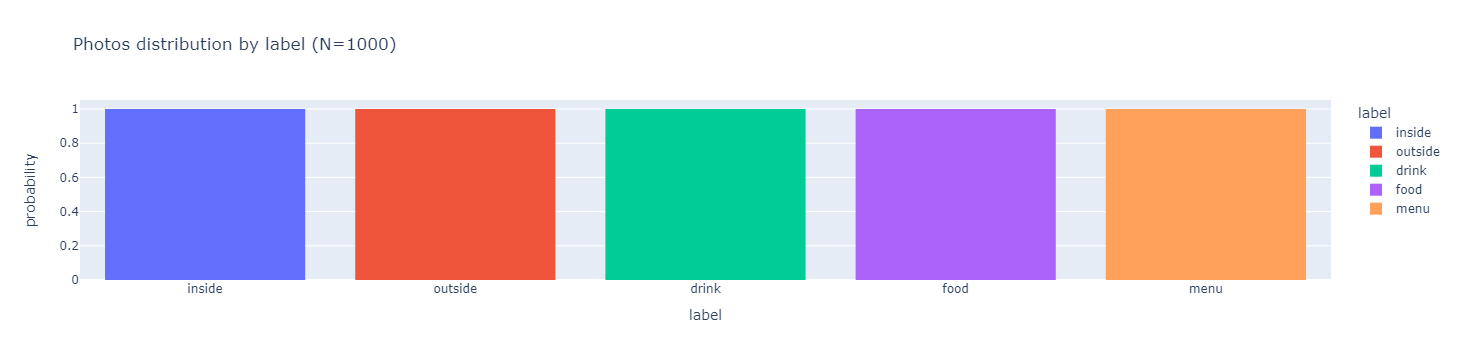

In [104]:
# Plot labels
px.histogram(
    photos_json,
    x="label",
    color="label",
    histnorm="probability",
    title=f"Photos distribution by label (N={len(photos_json['label'])})",
)

In [105]:
# Reset the index of DataFrame
# reset_index() method sets a list of integer ranging from 0 to length of data as index.

photos_json = photos_json.reset_index()
del photos_json["index"]
photos_json.head(2)

,photo_id,business_id,caption,label,photo
0,cO58-hmFkBxDUQ4B0p40AA,v8IBu8Td9IuIvbcmHv9ZRA,You can bring in a framed pic of your pup to p...,inside,C:\Users\ezequ\proyectos\openclassrooms\Projet...
1,7_hiXIbS5Ub0_eiRxr5COg,7rMxt2f3uvC6xPQtHgQKLQ,,inside,C:\Users\ezequ\proyectos\openclassrooms\Projet...


#### Display sample images by label
Let's look at 3 images per category.

In [106]:
list_photos = photos_json["photo"]

In [107]:
data = photos_json.copy()

drink


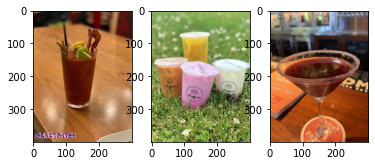

food


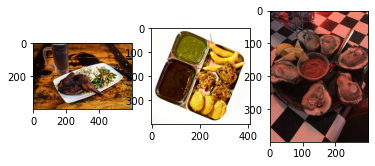

inside


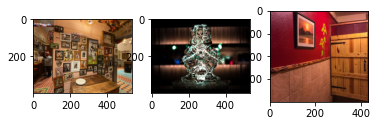

menu


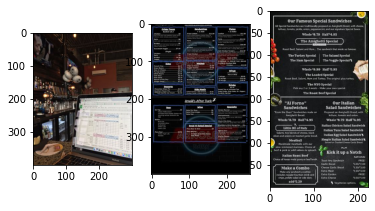

outside


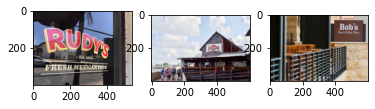

In [108]:
def list_fct(name) :
    list_image_name = [data["photo"][i] for i in range(len(data)) if data["label"][i]==name]
    return list_image_name

list_labels = ["drink", "food", "inside", "menu", "outside"]

list_drink=[list_photos[i] for i in range(len(data)) if data["label"][i]=="drink"]
list_food=[list_photos[i] for i in range(len(data)) if data["label"][i]=="food"]
list_inside=[list_photos[i] for i in range(len(data)) if data["label"][i]=="inside"]
list_menu=[list_photos[i] for i in range(len(data)) if data["label"][i]=="menu"]
list_outside=[list_photos[i] for i in range(len(data)) if data["label"][i]=="outside"]

for name in list_labels :
    print(name)
    # print("-------")
    for i in range(3):
        plt.subplot(130 + 1 + i)
        filename = list_fct(name)[i]
        image = imread(filename)
        plt.imshow(image)
    plt.show()

As we can see, that the images are of different sizes. It is therefore necessary to scale them all to the same size. We are also going to improve the contrast, for this we create a function.

#### Scalling and filtering in one image
Before creating the function, let's perform some tests on an image.

In [109]:
#let's start with one define photo
photo_path = 'C:\\Users\\ezequ\\proyectos\\openclassrooms\\Projet_6\\data\\raw\\yelp_photos\\photos\\__02nEL2xViYvZihvV4_hw.jpg'
image = io.imread(photo_path)

In [110]:
# Photo information
print( 'photo path :', photo_path)
print( 'classe :', type(image) )
print( 'type :', image.dtype )
print( 'taille :', image.shape )

photo path : C:\Users\ezequ\proyectos\openclassrooms\Projet_6\data\raw\yelp_photos\photos\__02nEL2xViYvZihvV4_hw.jpg
classe : <class 'numpy.ndarray'>
type : uint8
taille : (400, 400, 3)


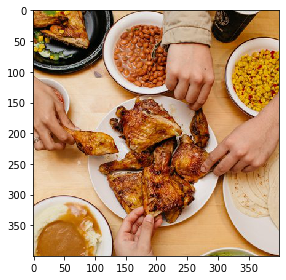

In [111]:
io.imshow(image)
io.show()

##### Resize

We will set a size of 200x250 px

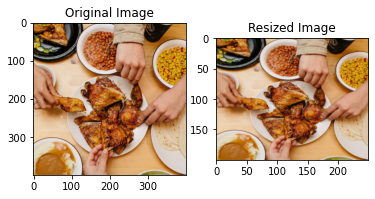

In [112]:
img_resized = resize(image, (200, 250))

#plot images to compare
plt.subplot(121)
plt.imshow(image)
plt.title('Original Image')
plt.subplot(122)
plt.imshow(img_resized)
plt.title('Resized Image')
plt.show()

##### Transformation of the image into black and white

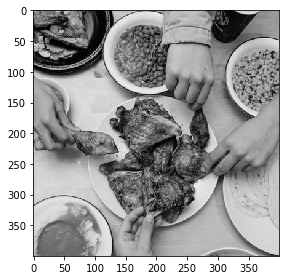

In [113]:
grey_image = color.rgb2gray( image )
io.imshow( grey_image )
io.show()

In [114]:
print( 'classe :', type(grey_image) )
print( 'type :', grey_image.dtype )
print( 'taille :', grey_image.shape )

classe : <class 'numpy.ndarray'>
type : float64
taille : (400, 400)


In [115]:
grey_image = grey_image*256

In [116]:
grey_image

array([[ 56.57539765,  64.18211137,  71.79264   , ..., 158.89307608,
        158.89307608, 159.89699765],
       [ 51.08565333,  68.00775529,  84.14870588, ..., 157.88915451,
        158.89307608, 158.89307608],
       [108.97849725, 152.43866353, 192.17468235, ..., 154.8773898 ,
        154.8773898 , 153.87346824],
       ...,
       [188.01674039, 190.08752941, 171.42643451, ..., 210.11044392,
        213.12220863, 216.13397333],
       [186.36318118, 180.83127216, 162.88456784, ..., 144.12388392,
        164.20231529, 177.25329569],
       [183.77808314, 170.71585882, 153.77307608, ...,  37.48522667,
         51.2485898 ,  63.15088314]])

Let's look at the contrast of the image using a histogram.

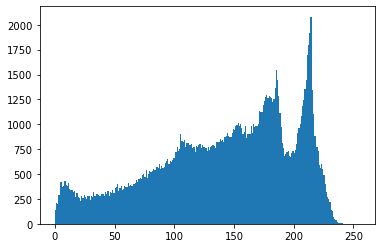

In [117]:
# Load image as pixel matrix
img = np.array(grey_image)

# Generate and display the histogram
# To normalise it: argument density=True in plt.hist
# To get the cumulative histogram: argument cumulative=True
n, bins, patches = plt.hist(img.flatten(), bins=range(256))
plt.show()

Equalisation of the grey level of the image.

In [118]:
img_corrected = exposure.equalize_hist(grey_image)

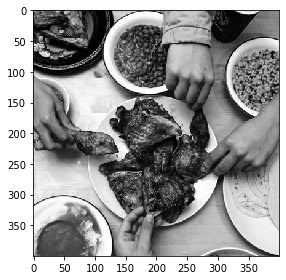

In [119]:
io.imshow(img_corrected)
io.show()

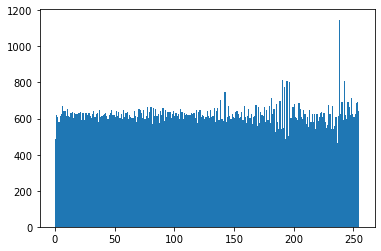

In [120]:
# Generate and display the histogram
# To normalise it: argument density=True in plt.hist
# To get the cumulative histogram: argument cumulative=True

img = np.array(img_corrected*256)
n, bins, patches = plt.hist(img.flatten(), bins=range(256))
plt.show()

We create a function to scale all images to the same size, but also to grey them out and equalise the contrast.
We also add a part for converting images for use with the Keras templates.

In [121]:
def clean_image(link_image, grey, float_img, size_l=224, size_h=224):
    try:
        image = io.imread(link_image)
        img_resized = resize(image, (size_l, size_h))
        if grey == 1:
            grey_image = color.rgb2gray( img_resized )
            img_corrected = exposure.equalize_hist(grey_image)
        elif grey==0:
            # img_resized = color.rgb2lab(img_resized)
            for channel in range(img_resized.shape[2]):  # equalizing each channel
                img_resized[:, :, channel] = exposure.equalize_hist(img_resized[:, :, channel])
                img_corrected = img_resized
            # img_corrected = exposure.equalize_hist(img_resized)
        if float_img == 1:
            img_corrected = img_as_ubyte(img_corrected)
        elif float_img == 2:
            #img_corrected = color.gray2rgb(img_corrected)
            img_corrected = img_to_array(img_corrected)
    except:
        img_corrected=None
    return img_corrected

    

In [122]:
data.head(2)

,photo_id,business_id,caption,label,photo
0,cO58-hmFkBxDUQ4B0p40AA,v8IBu8Td9IuIvbcmHv9ZRA,You can bring in a framed pic of your pup to p...,inside,C:\Users\ezequ\proyectos\openclassrooms\Projet...
1,7_hiXIbS5Ub0_eiRxr5COg,7rMxt2f3uvC6xPQtHgQKLQ,,inside,C:\Users\ezequ\proyectos\openclassrooms\Projet...


We create a column with the images resized, equalized and greyscale.

In [123]:
# Use the .progress_apply()method if you want to show a progress indicator while performing your Pandas series operations. 
#The progress_apply() method is part of the originally created tqdm package which enables you to create a progress meter and estimate “Time To Completion” for your iterations.

data["img_corrected"] = data["photo"].progress_apply(lambda x: clean_image(x, 1, 1, 224, 224))

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:29<00:00, 33.76it/s]


We add a column with the images resized, equalized, in colour and in ubyte format

In [124]:
data["img_corrected_float"] = data["photo"].progress_apply(lambda x: clean_image(x, 0, 2, 224, 224))

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:29<00:00, 34.03it/s]


We add a column with the images resized, equalized, in colour and in array format

In [125]:
data["img_corrected_float_2"] = data["photo"].progress_apply(lambda x: clean_image(x, 1, 0, 224, 224))

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:25<00:00, 39.45it/s]


In [126]:
data = data.loc[pd.isnull(data["img_corrected_float"]) == False]

In [127]:
data.shape

(1000, 8)

It is necessary to encode the image category variable digitally in order to be able to use the templates in the future.

In [128]:
le = preprocessing.LabelEncoder()
data["label_num"] = le.fit_transform(data["label"])

In [129]:
data.head(2)

,photo_id,business_id,caption,label,photo,img_corrected,img_corrected_float,img_corrected_float_2,label_num
0,cO58-hmFkBxDUQ4B0p40AA,v8IBu8Td9IuIvbcmHv9ZRA,You can bring in a framed pic of your pup to p...,inside,C:\Users\ezequ\proyectos\openclassrooms\Projet...,"[[113, 110, 105, 101, 100, 98, 97, 96, 97, 102...","[[[0.47935095, 0.43806732, 0.4477596], [0.4681...","[[0.4445159341621353, 0.4300987470654559, 0.41...",2
1,7_hiXIbS5Ub0_eiRxr5COg,7rMxt2f3uvC6xPQtHgQKLQ,,inside,C:\Users\ezequ\proyectos\openclassrooms\Projet...,"[[53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, ...","[[[0.18849649, 0.21791294, 0.22450973], [0.188...","[[0.2096221301020408, 0.2096221301020408, 0.20...",2


In [130]:
data["img_corrected_float"].shape

(1000,)

In [131]:
data.shape

(1000, 9)

In [132]:
photo_test = data["img_corrected_float_2"].head(1)

In [133]:
photo_test

0    [[0.4445159341621353, 0.4300987470654559, 0.41...
Name: img_corrected_float_2, dtype: object

In [134]:
photo_test = np.array(photo_test)

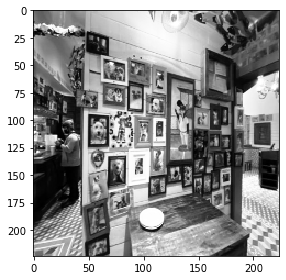

In [135]:
io.imshow(photo_test[0])
io.show()

In [136]:
gray1 = photo_test[0].copy()

In [137]:
gray1

array([[0.44451593, 0.43009875, 0.41197302, ..., 0.17463615, 0.24579164,
        0.35017003],
       [0.44123808, 0.42725454, 0.4079498 , ..., 0.17316867, 0.26852528,
        0.36098986],
       [0.44671679, 0.43266863, 0.41365183, ..., 0.17008176, 0.30813435,
        0.36535342],
       ...,
       [0.69577585, 0.63053928, 0.43311458, ..., 0.8969311 , 0.92646353,
        0.92744837],
       [0.66130087, 0.6044236 , 0.44992617, ..., 0.89729874, 0.89069123,
        0.90951279],
       [0.66643806, 0.62235755, 0.45274727, ..., 0.85829887, 0.90470166,
        0.88880163]])

Now that we have processed our images, we can move on to adding features.

### Features creation : SIFT

We decide to detect the key points using the SIFT method. There are other methods, but this one ensures rotation invariance by finding the dominant orientation in a circular neighbourhood around each detected feature. 


Let's test on an image

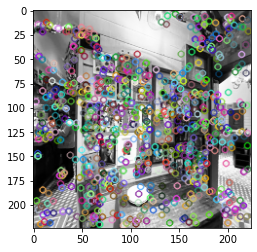

In [138]:
#keypoints
sift = cv2.xfeatures2d.SIFT_create()
image8bit = cv2.normalize(gray1, None, 0, 255, cv2.NORM_MINMAX).astype('uint8')
keypoints_1, descriptors_1 = sift.detectAndCompute(image8bit,None)

img_1 = cv2.drawKeypoints(image8bit,keypoints_1,image8bit)
plt.imshow(img_1)

SIFT detects some noise in the template. But we will use this method.

In [139]:
descriptors_1

array([[ 0.,  0.,  0., ...,  2.,  2., 16.],
       [64., 53., 56., ...,  0.,  0.,  0.],
       [41., 22.,  0., ...,  7., 10., 38.],
       ...,
       [ 0.,  1., 10., ...,  4.,  0.,  1.],
       [40.,  7., 25., ...,  0.,  0., 12.],
       [ 5., 11., 46., ...,  0.,  0.,  0.]], dtype=float32)

In [140]:
len(descriptors_1)
np.shape(descriptors_1)

(818, 128)

In [141]:
data.shape

(1000, 9)

In [142]:
sift_keypoints = []
sift_keypoints_all = []

Let's detect the descriptors in our images with the SIFT method.

In [143]:
sift_keypoints = []
temps1=time.time()
sift = cv2.xfeatures2d.SIFT_create(500)

for image in data["img_corrected"] :
    kp, des = sift.detectAndCompute(image, None)
    sift_keypoints.append(des)

sift_keypoints_by_img = np.asarray(sift_keypoints)
sift_keypoints_all    = np.concatenate(sift_keypoints_by_img, axis=0)

print()
print("Number of descriptors : ", sift_keypoints_all.shape)

duration1=time.time()-temps1
print("processing time SIFT descriptor : ", "%15.2f" % duration1, "seconds")


Number of descriptors :  (425598, 128)
processing time SIFT descriptor :            25.36 seconds


C:\Users\ezequ\AppData\Local\Temp\ipykernel_26300\768707878.py:9: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.



In [144]:
#descriptors_sift(data["img_corrected"], 500)
def descriptors_sift(df_var, n_desc):
    sift_keypoints_all = []
    sift_keypoints = []
    temps1=time.time()
    sift = cv2.xfeatures2d.SIFT_create(n_desc)
    for image in df_var :
        kp, des = sift.detectAndCompute(image, None)
        sift_keypoints.append(des)
    sift_keypoints_by_img = np.asarray(sift_keypoints)
    sift_keypoints_all    = np.concatenate(sift_keypoints_by_img, axis=0)
    print()
    print("Number of descriptors : ", sift_keypoints_all.shape)
    duration1=time.time()-temps1
    print("processing time SIFT descriptor : ", "%15.2f" % duration1, "seconds")
    return sift_keypoints_all, sift_keypoints
    

Now we can apply a classification method. Let us first test K-means.

### K-means + T-SNE

In [145]:
# Determination number of clusters based on square root 
temps1=time.time()

k = int(round(np.sqrt(len(sift_keypoints_all)),0))
print("Estimated number of clusters : ", k)
print("Creation of",k, "clusters of descriptors ...")

# Clustering
kmeans = cluster.MiniBatchKMeans(n_clusters=k, init_size=3*k, random_state=0)
kmeans.fit(sift_keypoints_all)

duration1=time.time()-temps1
print("processing time kmeans : ", "%15.2f" % duration1, "seconds")


Estimated number of clusters :  652
Creation of 652 clusters of descriptors ...
processing time kmeans :            11.65 seconds


##### Addition of new features : 
- for each image, calculation of the histogram = count for each cluster number, the number of descriptors of the image

In [146]:
# Creation of histograms (features)
temps1=time.time()

def build_histogram(kmeans, des, image_num):
    res = kmeans.predict(des)
    hist = np.zeros(len(kmeans.cluster_centers_))
    nb_des=len(des)
    if nb_des==0 : print("Problem with histogram image  : ", image_num)
    for i in res:
        hist[i] += 1.0/nb_des
    return hist


# Creation of a matrix of histograms
hist_vectors=[]

for i, image_desc in enumerate(sift_keypoints_by_img) :
    if i%100 == 0 : print(i)  
    hist = build_histogram(kmeans, image_desc, i) #calculates the histogram
    hist_vectors.append(hist) #histogram is the feature vector

im_features = np.asarray(hist_vectors)

duration1=time.time()-temps1
print("creation time histograms : ", "%15.2f" % duration1, "seconds")


0
100
200
300
400
500
600
700
800
900
creation time histograms :            51.49 seconds


Visualisons nos résultats à l'aide d'une ACP ou d'une T-SNE

### Multidimensional analysis: PCA / T-SNE

#### PCA

In [147]:
print("Dataset dimensions before PCA reduction  : ", im_features.shape)
pca = decomposition.PCA(n_components=0.99)
feat_pca= pca.fit_transform(im_features)
print("Dataset dimensions after PCA reduction  : ", feat_pca.shape)

Dataset dimensions before PCA reduction  :  (1000, 652)
Dataset dimensions after PCA reduction  :  (1000, 537)


#### T-SNE

To begin, let's draw a T-SNE with the category indicator.

In [148]:
tsne = TSNE(n_components=2, perplexity=30, 
                     n_iter=2000, init='random', random_state=6)
X_tsne = tsne.fit_transform(feat_pca)

df_tsne = pd.DataFrame(X_tsne[:,0:2], columns=['tsne1', 'tsne2'])
df_tsne["class"] = data["label"]
print(df_tsne.shape)

C:\Users\ezequ\miniconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



(1000, 3)


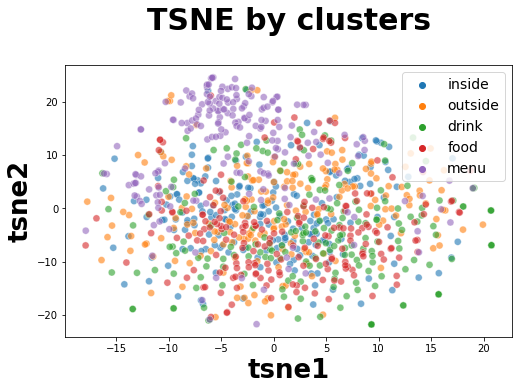

In [149]:
plt.figure(figsize=(8,5))
sns.scatterplot(
    x="tsne1", y="tsne2", hue="class", data=df_tsne, legend="brief",
    palette=sns.color_palette('tab10', n_colors=5), s=50, alpha=0.6)

plt.title('TSNE by clusters', fontsize = 30, pad = 35, fontweight = 'bold')
plt.xlabel('tsne1', fontsize = 26, fontweight = 'bold')
plt.ylabel('tsne2', fontsize = 26, fontweight = 'bold')
plt.legend(prop={'size': 14}) 

plt.show()

We observe that our data is scattered. This is logical because when a picture is taken of a drink, the dish may also be in the frame of the picture.

Let us try to apply k-means on the T-SNE data.

### K-means

We have to take into account 5 clusters.

In [150]:
cls = cluster.KMeans(n_clusters=5, random_state=6)
cls.fit(X_tsne)

df_tsne["cluster"] = cls.labels_
print(df_tsne.shape)

(1000, 4)


In [151]:
df_tsne

,tsne1,tsne2,class,cluster
0,-10.650325,-2.182698,inside,1
1,17.035482,9.403192,inside,4
2,8.122166,10.071305,inside,4
3,-2.665733,9.705720,inside,3
4,-2.187619,-0.580359,inside,1
...,...,...,...,...
995,-7.928591,15.012451,menu,3
996,-10.890906,-2.443279,menu,1
997,-0.493036,6.200819,menu,1
998,-6.212207,23.252838,menu,3


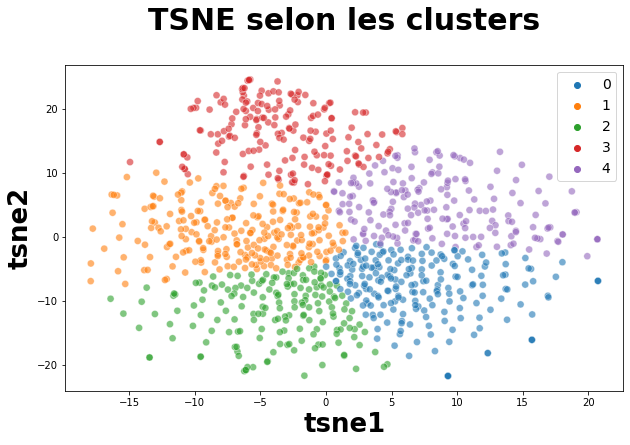

ARI :  0.09559189318042853


In [152]:
plt.figure(figsize=(10,6))
sns.scatterplot(
    x="tsne1", y="tsne2",
    hue="cluster",
    palette=sns.color_palette('tab10', n_colors=5), s=50, alpha=0.6,
    data=df_tsne,
    legend="brief")

plt.title('TSNE selon les clusters', fontsize = 30, pad = 35, fontweight = 'bold')
plt.xlabel('tsne1', fontsize = 26, fontweight = 'bold')
plt.ylabel('tsne2', fontsize = 26, fontweight = 'bold')
plt.legend(prop={'size': 14})

plt.show()

labels = data["label_num"]
print("ARI : ", metrics.adjusted_rand_score(labels, cls.labels_))

We observe that our data have been split into classes by "region". The algorithm was therefore unable to detect our categories correctly. This can be explained by the fact that, as we noted earlier, if we take a picture of a drink, we may have the dish in the background.

Let us calculate a confusion matrix.

In [153]:
df_tsne.groupby("cluster").count()["class"]

cluster
0    212
1    247
2    175
3    179
4    187
Name: class, dtype: int64

In [154]:
conf_mat = metrics.confusion_matrix(data["label_num"], cls.labels_)
print(conf_mat)

[[ 77  19  47  15  42]
 [ 61  44  52  16  27]
 [ 47  77  29  15  32]
 [  6  45  10 118  21]
 [ 21  62  37  15  65]]


In [155]:
def conf_mat_transform(y_true,y_pred) :
    conf_mat = metrics.confusion_matrix(y_true,y_pred)
    
    # argmax() => Returns the indices of the maximum values along an axis.
    corresp = np.argmax(conf_mat, axis=0)
#     corresp = [4, 3, 1, 2, 0]
    print ("Cluster matching : ", corresp)
    # y_pred_transform = np.apply_along_axis(correspond_fct, 1, y_pred)
    labels = pd.Series(y_true, name="y_true").to_frame()
    labels['y_pred'] = y_pred
    labels['y_pred_transform'] = labels['y_pred'].apply(lambda x : corresp[x])
    
    return labels['y_pred_transform']

cls_labels_transform = conf_mat_transform(labels, cls.labels_)
conf_mat = metrics.confusion_matrix(labels, cls_labels_transform)
print(conf_mat)
print()
print(metrics.classification_report(labels, cls_labels_transform))

Cluster matching :  [0 2 1 3 4]
[[ 77  47  19  15  42]
 [ 61  52  44  16  27]
 [ 47  29  77  15  32]
 [  6  10  45 118  21]
 [ 21  37  62  15  65]]

              precision    recall  f1-score   support

           0       0.36      0.39      0.37       200
           1       0.30      0.26      0.28       200
           2       0.31      0.39      0.34       200
           3       0.66      0.59      0.62       200
           4       0.35      0.33      0.34       200

    accuracy                           0.39      1000
   macro avg       0.40      0.39      0.39      1000
weighted avg       0.40      0.39      0.39      1000



<AxesSubplot:>

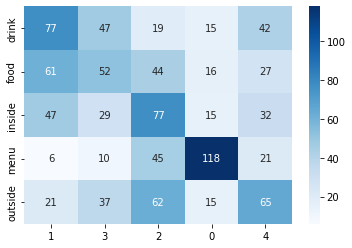

In [156]:
df_cm = pd.DataFrame(conf_mat, index = [label for label in list_labels],
                  columns = [i for i in "13204"])
plt.figure(figsize = (6,4))
sns.heatmap(df_cm, annot=True, fmt="d", cmap="Blues")

We can see that the classifier is actually quite bad (F1 score ~ 0.25).

We can see that our model performs very well on "menu" photos, as well as "inside" photos. But it performs poorly on "drink" and "interior" and "outside" photos.

### Image classification with a CNN
We are going to use a pre-trained CNN to label the photos.

#### Basic photo labelling
First, we are going to test the photo labelling feature of the pre-trained CNN on one example of our dataset.

We are going to use VGG16 from Keras to extract the features of the photos and predict the best labels among the 1000 classes the model has learned.

In [157]:
photos_json["file_name"] = [x + ".jpg" for x in photos_json["photo_id"]]
photos_json

,photo_id,business_id,caption,label,photo,file_name
0,cO58-hmFkBxDUQ4B0p40AA,v8IBu8Td9IuIvbcmHv9ZRA,You can bring in a framed pic of your pup to p...,inside,C:\Users\ezequ\proyectos\openclassrooms\Projet...,cO58-hmFkBxDUQ4B0p40AA.jpg
1,7_hiXIbS5Ub0_eiRxr5COg,7rMxt2f3uvC6xPQtHgQKLQ,,inside,C:\Users\ezequ\proyectos\openclassrooms\Projet...,7_hiXIbS5Ub0_eiRxr5COg.jpg
2,XseBUNM81RxxtfDgyjxXiA,Uw46n__imJ52D7Zh1vJVrQ,The Cowgirl's bathroom looks like a barn with ...,inside,C:\Users\ezequ\proyectos\openclassrooms\Projet...,XseBUNM81RxxtfDgyjxXiA.jpg
3,_IRUZoGYSr9bICvBJrPnhw,3oFE-751lsSdkggDd7L-aw,We ID.,inside,C:\Users\ezequ\proyectos\openclassrooms\Projet...,_IRUZoGYSr9bICvBJrPnhw.jpg
4,x8xVVzTI3yW5xZraRZNxfQ,NetawOi6wDa1mGJumW4-zQ,,inside,C:\Users\ezequ\proyectos\openclassrooms\Projet...,x8xVVzTI3yW5xZraRZNxfQ.jpg
...,...,...,...,...,...,...
995,FYcHZXujQX0GGs1oevYfdQ,jyRQNFeaGhdZBgf4kkWFlA,,menu,C:\Users\ezequ\proyectos\openclassrooms\Projet...,FYcHZXujQX0GGs1oevYfdQ.jpg
996,PP2dCAxKLHMzqNAQfoeerw,AvMhoV5RbPzm1TFuW8WEDQ,Yummy Noodles,menu,C:\Users\ezequ\proyectos\openclassrooms\Projet...,PP2dCAxKLHMzqNAQfoeerw.jpg
997,WiRnjbxlRNGBrCzYDhybWA,3VZsvccKrkvmBshoAFrgGw,Menu,menu,C:\Users\ezequ\proyectos\openclassrooms\Projet...,WiRnjbxlRNGBrCzYDhybWA.jpg
998,Wc-r1NIkj8VvpajjOFa1YA,g2hkkxwC2llfR-eYr0HPvQ,,menu,C:\Users\ezequ\proyectos\openclassrooms\Projet...,Wc-r1NIkj8VvpajjOFa1YA.jpg


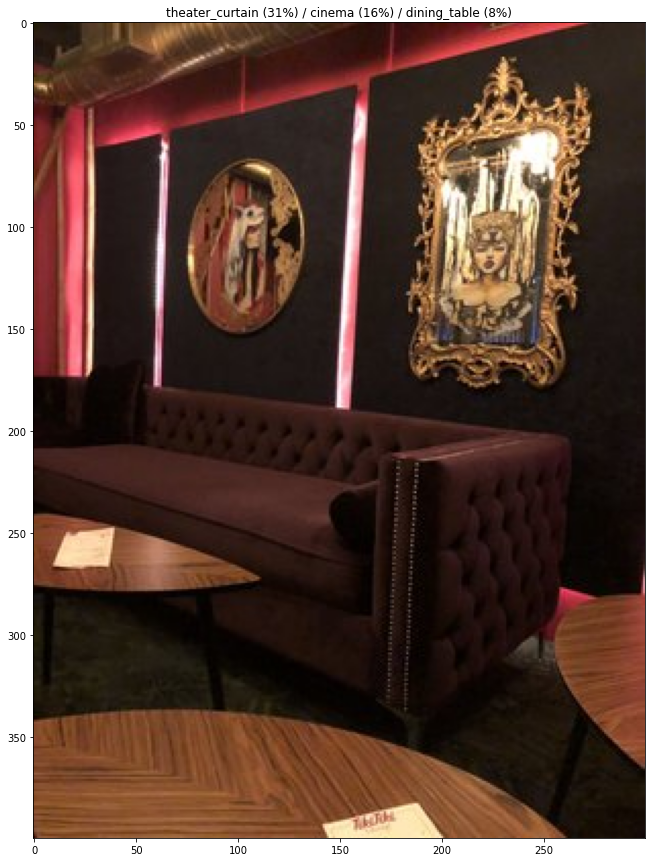

In [158]:
# Pick a random photo
photo = photos_json.sample().iloc[0]
img_path = os.path.join("C:\\Users\\ezequ\\proyectos\\openclassrooms\\Projet_6\\data\\raw\\yelp_photos\\photos\\", photo["file_name"])


# Création du modèle VGG-16 implementé par Keras
model = VGG16() 

# Load image
img = load_img(img_path, target_size=(224, 224))  
# Convert to numpy array
img = img_to_array(img)  
# Create the image collection (one sample)
img = img.reshape((1, img.shape[0], img.shape[1], img.shape[2]))  
# Preprocess the image as required by VGG-16
img = preprocess_input(img)  

# Predetermine the class of the image (among the 1000 classes of ImageNet)
pred = model.predict(img) 

predictions = decode_predictions(pred, top=3)[0]
query_img = cv2.cvtColor(cv2.imread(img_path, flags=cv2.IMREAD_COLOR), cv2.COLOR_BGR2RGB)
plt.figure(figsize=(15, 15))
plt.imshow(query_img)
plt.title(
    f"{predictions[0][1]} ({round(100*predictions[0][2])}%) / {predictions[1][1]} ({round(100*predictions[1][2])}%) / {predictions[2][1]} ({round(100*predictions[2][2])}%)"
)
plt.show()

We can see that even without any work from our part, the model is very good at describing what the photo represents.

Now we want to use this model to predict our classes ("food", "drink, "menu", "interior" and "outside").

### Transfer learning
We want to reuse the pre-trained CNN to learn and predict the labels of our own photos. For that, we are going to implement the "feature extraction" part of the transfer learning.

#### Model definition
First, we need to define the model. We will use VGG16 as a base model, and we will add our own fully connected layers for the prediction of our labels.

In [159]:
# Load VGG-16 pre-trained on ImageNet and without fully-connected layers (include_top=False)
vgg_model = VGG16(weights="imagenet", include_top=False, input_shape=(224, 224, 3))

for layer in vgg_model.layers:
    layer.trainable = False
    
vgg_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

We observe we have 0 trainable parameters, so we are able to use VGG16 for features extraction

Let's define X and Y

In [160]:
X = data["img_corrected_float"]

In [161]:
X_vgg = list(X)
X_vgg_2 = np.array(X_vgg)

In [162]:
X_vgg_2.shape

(1000, 224, 224, 3)

In [163]:
Y = data["label_num"]

In [164]:
Y_vgg = list(Y)

In [165]:
Y_vgg_2 = np.array(Y_vgg)

In [166]:
Y_vgg_2.shape

(1000,)

Now, let's extract the features using the convolutional network VGG

In [167]:
feature_extractor = vgg_model.predict(X_vgg_2)

In [168]:
feature_extractor.shape

(1000, 7, 7, 512)

Let's reshape the extracted features for the PCA and T-SNE 

In [169]:
features = feature_extractor.reshape(feature_extractor.shape[0], -1)
features.shape

(1000, 25088)

#### PCA

We will prepare the data for the dimensional reduction

In [170]:
data_2 = data.copy()

In [171]:
data2 = data.reset_index()
del data2["index"]
data2 = data2.reset_index()

In [172]:
df_pred = pd.DataFrame(features).reset_index()
df_pred

,index,0,1,2,3,4,5,6,7,8,...,25078,25079,25080,25081,25082,25083,25084,25085,25086,25087
0,0,1.011023,0.0,1.447867,0.157586,0.000000,0.0,0.000000,0.268810,0.0,...,0.968231,0.000000,0.0,0.336693,0.980361,0.000000,0.000000,0.000000,1.072322,0.0
1,1,1.020626,0.0,0.000000,0.000000,0.195278,0.0,0.070842,0.000000,0.0,...,1.802760,0.000000,0.0,0.000000,0.000000,0.260533,0.000000,0.000000,0.477163,0.0
2,2,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,...,1.510495,0.319779,0.0,0.000000,0.000000,0.406834,0.241167,0.000000,0.986505,0.0
3,3,0.689748,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,...,1.209102,0.000000,0.0,0.000000,0.571258,0.111708,0.212795,0.000000,1.121129,0.0
4,4,0.711575,0.0,0.401418,0.000000,0.000000,0.0,0.000000,0.000000,0.0,...,0.946247,0.094346,0.0,0.000000,0.000000,0.531832,0.370839,0.000000,1.495839,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,995,0.597452,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,...,2.023989,0.135701,0.0,0.000000,0.000000,0.221357,0.935632,0.000000,0.455920,0.0
996,996,0.974329,0.0,0.248546,0.000000,0.000000,0.0,0.000000,0.000000,0.0,...,1.354594,0.000000,0.0,0.000000,0.000000,0.580855,0.000000,0.000000,0.410717,0.0
997,997,0.544117,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,...,1.903671,0.000000,0.0,0.000000,0.000000,0.210907,0.110092,0.065807,0.321675,0.0
998,998,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,...,1.465332,0.033483,0.0,0.000000,0.000000,0.050204,0.700089,0.000000,0.263966,0.0


In [173]:
data_vgg = data2.merge(df_pred, how="left", on="index")
data_vgg.head(2)

,index,photo_id,business_id,caption,label,photo,img_corrected,img_corrected_float,img_corrected_float_2,label_num,...,25078,25079,25080,25081,25082,25083,25084,25085,25086,25087
0,0,cO58-hmFkBxDUQ4B0p40AA,v8IBu8Td9IuIvbcmHv9ZRA,You can bring in a framed pic of your pup to p...,inside,C:\Users\ezequ\proyectos\openclassrooms\Projet...,"[[113, 110, 105, 101, 100, 98, 97, 96, 97, 102...","[[[0.47935095, 0.43806732, 0.4477596], [0.4681...","[[0.4445159341621353, 0.4300987470654559, 0.41...",2,...,0.968231,0.0,0.0,0.336693,0.980361,0.000000,0.0,0.0,1.072322,0.0
1,1,7_hiXIbS5Ub0_eiRxr5COg,7rMxt2f3uvC6xPQtHgQKLQ,,inside,C:\Users\ezequ\proyectos\openclassrooms\Projet...,"[[53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, ...","[[[0.18849649, 0.21791294, 0.22450973], [0.188...","[[0.2096221301020408, 0.2096221301020408, 0.20...",2,...,1.802760,0.0,0.0,0.000000,0.000000,0.260533,0.0,0.0,0.477163,0.0


In [174]:
data_vgg = data_vgg.drop(["index"], axis=1)
data_vgg.head(2)

,photo_id,business_id,caption,label,photo,img_corrected,img_corrected_float,img_corrected_float_2,label_num,0,...,25078,25079,25080,25081,25082,25083,25084,25085,25086,25087
0,cO58-hmFkBxDUQ4B0p40AA,v8IBu8Td9IuIvbcmHv9ZRA,You can bring in a framed pic of your pup to p...,inside,C:\Users\ezequ\proyectos\openclassrooms\Projet...,"[[113, 110, 105, 101, 100, 98, 97, 96, 97, 102...","[[[0.47935095, 0.43806732, 0.4477596], [0.4681...","[[0.4445159341621353, 0.4300987470654559, 0.41...",2,1.011023,...,0.968231,0.0,0.0,0.336693,0.980361,0.000000,0.0,0.0,1.072322,0.0
1,7_hiXIbS5Ub0_eiRxr5COg,7rMxt2f3uvC6xPQtHgQKLQ,,inside,C:\Users\ezequ\proyectos\openclassrooms\Projet...,"[[53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, ...","[[[0.18849649, 0.21791294, 0.22450973], [0.188...","[[0.2096221301020408, 0.2096221301020408, 0.20...",2,1.020626,...,1.802760,0.0,0.0,0.000000,0.000000,0.260533,0.0,0.0,0.477163,0.0


In [175]:
pca_vgg = data_vgg.copy()
pca_vgg = pca_vgg.drop(["photo_id", "business_id", "caption", "label", "photo", "img_corrected", "img_corrected_float", "img_corrected_float_2"], axis=1)
pca_vgg.head(2)

,label_num,0,1,2,3,4,5,6,7,8,...,25078,25079,25080,25081,25082,25083,25084,25085,25086,25087
0,2,1.011023,0.0,1.447867,0.157586,0.000000,0.0,0.000000,0.26881,0.0,...,0.968231,0.0,0.0,0.336693,0.980361,0.000000,0.0,0.0,1.072322,0.0
1,2,1.020626,0.0,0.000000,0.000000,0.195278,0.0,0.070842,0.00000,0.0,...,1.802760,0.0,0.0,0.000000,0.000000,0.260533,0.0,0.0,0.477163,0.0


In [176]:
print("Dataset dimensions before PCA reduction : ", pca_vgg.shape)
pca = decomposition.PCA(n_components=0.99)
feat_pca= pca.fit_transform(pca_vgg)
print("Dataset dimensions after PCA reduction : ", feat_pca.shape)

Dataset dimensions before PCA reduction :  (1000, 25089)


C:\Users\ezequ\miniconda3\lib\site-packages\sklearn\utils\validation.py:1673: FutureWarning:

Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.



Dataset dimensions after PCA reduction :  (1000, 925)


#### T-SNE

To begin, let's draw a T-SNE with the category indicator.

In [177]:
tsne = TSNE(n_components=2, perplexity=30, 
                     n_iter=2000, init='random', random_state=6)
X_tsne = tsne.fit_transform(feat_pca)

df_tsne = pd.DataFrame(X_tsne[:,0:2], columns=['tsne1', 'tsne2'])
df_tsne["class"] = data["label"]
df_tsne["class_num"] = data["label_num"]
print(df_tsne.shape)

C:\Users\ezequ\miniconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



(1000, 4)


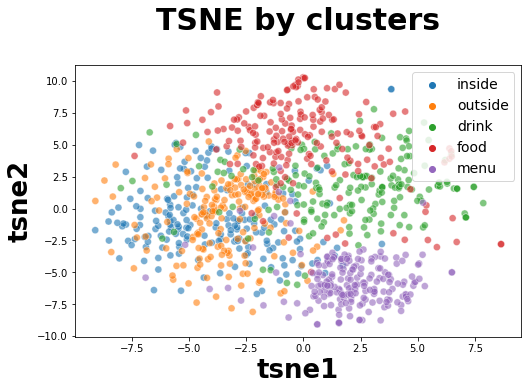

In [178]:
plt.figure(figsize=(8,5))
sns.scatterplot(
    x="tsne1", y="tsne2", hue="class", data=df_tsne, legend="brief",
    palette=sns.color_palette('tab10', n_colors=5), s=50, alpha=0.6)

plt.title('TSNE by clusters', fontsize = 30, pad = 35, fontweight = 'bold')
plt.xlabel('tsne1', fontsize = 26, fontweight = 'bold')
plt.ylabel('tsne2', fontsize = 26, fontweight = 'bold')
plt.legend(prop={'size': 14}) 

plt.show()

We observe that our data is scattered. This is logical because when a picture is taken of a drink, the dish may also be in the frame of the picture.

Let us try to apply k-means on the T-SNE data.

### K-means

We have to take into account 5 clusters.

In [179]:
cls = cluster.KMeans(n_clusters=5, random_state=6)
cls.fit(X_tsne)

df_tsne["cluster"] = cls.labels_
print(df_tsne.shape)

(1000, 5)


In [180]:
df_tsne

,tsne1,tsne2,class,class_num,cluster
0,-4.947165,-1.278122,inside,2,0
1,-0.374399,2.959263,inside,2,4
2,-1.326113,-3.085391,inside,2,0
3,-4.008355,-2.672516,inside,2,0
4,-7.574758,0.767603,inside,2,0
...,...,...,...,...,...
995,4.547883,-7.082594,menu,3,2
996,0.357153,-6.069936,menu,3,2
997,0.492544,-6.513430,menu,3,2
998,1.046467,-6.033433,menu,3,2


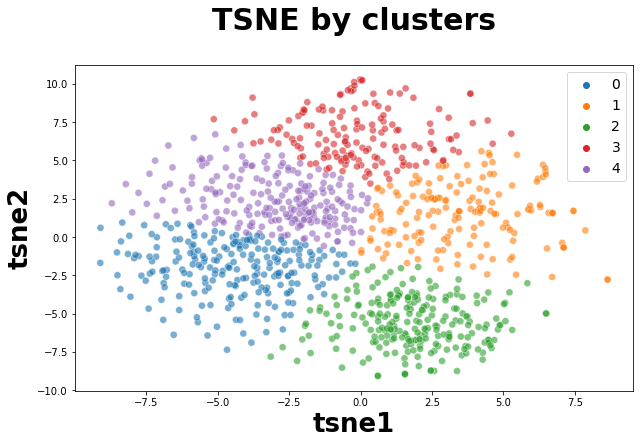

ARI :  0.4143705704190277


In [181]:
plt.figure(figsize=(10,6))
sns.scatterplot(
    x="tsne1", y="tsne2",
    hue="cluster",
    palette=sns.color_palette('tab10', n_colors=5), s=50, alpha=0.6,
    data=df_tsne,
    legend="brief")

plt.title('TSNE by clusters', fontsize = 30, pad = 35, fontweight = 'bold')
plt.xlabel('tsne1', fontsize = 26, fontweight = 'bold')
plt.ylabel('tsne2', fontsize = 26, fontweight = 'bold')
plt.legend(prop={'size': 14})

plt.show()

labels = data["label_num"]
print("ARI : ", metrics.adjusted_rand_score(labels, cls.labels_))

The T-SNE allows us to distinguish our groups correctly. But they remain quite close to each other. 

In [182]:
df_tsne.groupby("cluster").count()["class"]

cluster
0    229
1    167
2    234
3    154
4    216
Name: class, dtype: int64

In [183]:
conf_mat = metrics.confusion_matrix(data["label_num"], cls.labels_)
print(conf_mat)

[[  6 128   9  19  38]
 [  3  29   5 133  30]
 [123   5  21   2  49]
 [  7   1 188   0   4]
 [ 90   4  11   0  95]]


In [184]:
def conf_mat_transform(y_true,y_pred) :
    conf_mat = metrics.confusion_matrix(y_true,y_pred)
    
    # argmax() => Returns the indices of the maximum values along an axis.
    corresp = np.argmax(conf_mat, axis=0)
#     corresp = [4, 3, 1, 2, 0]
    print ("Cluster matching : ", corresp)
    # y_pred_transform = np.apply_along_axis(correspond_fct, 1, y_pred)
    labels = pd.Series(y_true, name="y_true").to_frame()
    labels['y_pred'] = y_pred
    labels['y_pred_transform'] = labels['y_pred'].apply(lambda x : corresp[x])
    
    return labels['y_pred_transform']

cls_labels_transform = conf_mat_transform(labels, cls.labels_)
conf_mat = metrics.confusion_matrix(labels, cls_labels_transform)
print(conf_mat)
print()
print(metrics.classification_report(labels, cls_labels_transform))

Cluster matching :  [2 0 3 1 4]
[[128  19   6   9  38]
 [ 29 133   3   5  30]
 [  5   2 123  21  49]
 [  1   0   7 188   4]
 [  4   0  90  11  95]]

              precision    recall  f1-score   support

           0       0.77      0.64      0.70       200
           1       0.86      0.67      0.75       200
           2       0.54      0.61      0.57       200
           3       0.80      0.94      0.87       200
           4       0.44      0.47      0.46       200

    accuracy                           0.67      1000
   macro avg       0.68      0.67      0.67      1000
weighted avg       0.68      0.67      0.67      1000



<AxesSubplot:>

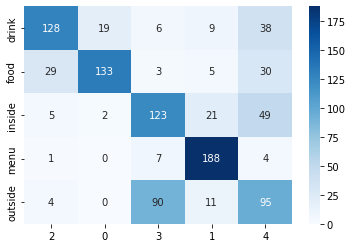

In [185]:
df_cm = pd.DataFrame(conf_mat, index = [label for label in list_labels],
                  columns = [i for i in "20314"])
plt.figure(figsize = (6,4))
sns.heatmap(df_cm, annot=True, fmt="d", cmap="Blues")

We can see that the classifier is actually not too bad (F1 score ~ 0.67).

We can see that our model performs very well on "menu" photos, as well as "food" and "drink"photos. But it performs poorly on "outside" photos since they are predict in label 3 and 4 with the same amount of photos.

### Conclusion: Image classification
The best solution is therefore the combination of VGG + T-SNE + K-means. This gives us better results.

## Conclusion
We were able to classify our images as we have just seen. We were able to demonstrate that the project is feasible.